In [1]:
import numpy as np
import plate_map as pm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from unidec_modules import unidectools as ud
from copy import deepcopy 
from unidec_modules.SeqChrom2 import *
import scipy
from copy import deepcopy
import copy
import os

In [2]:
folder = "D:\\211117 charlie ms\\mzml\\H7D"
map_path = "C:\\Users\\cm19ljc\\Documents\\GitHub\\UniDec\\reaction maps\\charlie_h7d.xlsx"

speciesheaders = {"Reaction":str, "Species":str, "Concentration":float,
                        "Units":str, "Mass":float, "Reagent Type":str, "Sequence":str}

speciesmap = pd.read_excel(map_path, 
                        dtype = speciesheaders,
                        sheet_name = 'species map')
speciesmap


,Reaction,Species,Concentration,Units,Mass,Reagent_Type,Sequence
0,ctb_mix,labelled,NaN,uM,12530.0,Protein,NaN
1,ctb_mix,unlabelled,NaN,uM,11855.0,Protein,NaN


In [3]:
splist = [Species(spval.to_dict('records')[0], name = spkey) for spkey, spval in speciesmap.groupby('Species')]
splist

[<labelled(Reaction = ctb_mix, Species = labelled, Concentration = nan, Units = uM, Mass = 12530.0, Reagent_Type = Protein, Sequence = nan, __name__ = labelled, peak = None, speciesmap = None, pmap = None, integral = [], color = black, cmap = viridis)>,
 <unlabelled(Reaction = ctb_mix, Species = unlabelled, Concentration = nan, Units = uM, Mass = 11855.0, Reagent_Type = Protein, Sequence = nan, __name__ = unlabelled, peak = None, speciesmap = None, pmap = None, integral = [], color = black, cmap = viridis)>]

In [4]:
clear_hdf5 = False
if clear_hdf5 == True:
    
    for dname, dirs, files in os.walk(folder):

        for fname in files:

            if fname[-4:] != "mzML":    
                path = os.path.join(dname, fname)
                os.remove(path)

In [5]:
def process_maps(self, groupby = 'Reaction'):

    

    # Reaction OR Substrate Conc

    self.pmap2 = self.pmap[self.pmap['Type'] != 'empty']
    self.pmap2.loc[:, 'Species'] = np.nan

    for skey, sval in self.speciesmap.groupby(['Reaction']):
        splist = [Species(spval.to_dict('records')[0], name = spkey) for spkey, spval in sval.groupby('Species')]
        splist = colorcodeclass(splist)

        for s in splist:
            self.pmap2.loc[:, s.__name__] = np.nan
            self.pmap2.loc[self.pmap2['Reaction']==skey, s.__name__] = self.pmap2.apply(lambda _:deepcopy(s), axis = 1)

        spnames = [s.__name__ for s in splist]
        self.pmap2.loc[self.pmap2['Reaction']==skey, 'Species'] = self.pmap2.apply(lambda _:spnames, axis = 1)

    # update_vars

    if len(self.data.spectra) == len(self.pmap2):
        for i, s in enumerate(self.data.spectra):
            well_id = self.pmap2.index[i]
            timevar = self.pmap2['Time'].iloc[i]
            s.attrs['Variable 1'] = well_id
            s.var1 = well_id
            s.attrs['Variable 2'] = timevar
            s.var2 = timevar
            self.pmap2.loc[well_id, 'Spectra'] = s



    spectra = {s.var1:s for s in self.data.spectra}

    # update species with well info/metadata 

    groupby = 'Reaction' # Reaction OR Substrate Conc

    for index, row in self.pmap2.iterrows():
        for specs in row['Species']:
            row[specs] = deepcopy(row[specs])
            row[specs].coord = row.name
    #         print(row[specs])
            vals = row[~row.index.isin(row['Species'])].to_dict()
            row[specs].__dict__.update(vals)
    return self
            

def peak_match(self, window = 10):
    window = 10

    intmat = np.array([])

    for index, row in self.pmap2.iterrows():

        rowints = np.array([])

        specieslist = list(row[row.index.isin(row['Species'])])
        theory_masses = np.array([sp.Mass for sp in specieslist])
        data_masses = np.array([p.mass for p in row['Spectra'].pks.peaks])
        pks = np.array([p for p in row['Spectra'].pks.peaks])

        # match algorithm 
        tm, dm = np.meshgrid(theory_masses, data_masses)
        diff = abs(tm - dm)
        diff[diff>window] = np.nan
        for i, d in enumerate(diff):
            if np.isnan(d).all()==False:
                minimum = np.nanargmin(d)
                data_peak = data_masses[i]

                specieslist[minimum].peak = pks[i]
                specieslist[minimum].integral = pks[i].integral[0]
                print("{}, {} = {}".format(row[row.index.isin(row['Species'])][minimum].__name__, data_peak, pks[i]))

                row[row.index.isin(row['Species'])][minimum].integral = pks[i].integral[0]
                row[row.index.isin(row['Species'])][minimum].peak = pks[i]
                np.append(rowints, pks[i].integral[0])
                print(row[row.index.isin(row['Species'])][minimum].integral)

    return self


In [6]:
def normalise_peaks(self):
    for index, row in self.pmap2.iterrows():
        ints = []
        for s in row[row['Species']]:
            if type(s.integral) != list:
                ints.append(s.integral)

    #     ints = np.array([s.integral for s in row[row['Species']]])
        sum_ints = np.sum(ints)
        for s in row[row['Species']]:
            if type(s.integral) != list:
                s.percentage = s.integral/sum_ints
            else:
                s.percentage = 0
            print("{}:{}".format(s.__name__, s.percentage))
            
    return self


In [7]:
#################################### NEW FILES PROCESSING #########################
filenames = os.listdir(folder)
engines = []
for dname, dirs, files in os.walk(folder):

    for fname in files:
        
        if fname[-4:] == "mzML":


            eng = SeqChrom()

            spectra_path = os.path.join(dname, fname)
            eng.load_mzml(spectra_path)
            print("loaded {}".format(spectra_path))
            engines.append(eng)


UniDec Engine v.4.4.0

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\UniDec\unidec_bin\UniDec.exe

UniDec Engine v.4.4.0

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\UniDec\unidec_bin\UniDec.exe
Opening HDF5 File: D:\211117 charlie ms\mzml\H7D\20211116 2 uM H7D 100 uM AYLPETGG 1 h_BC6_01_80279.hdf5
Reading mzML: D:\211117 charlie ms\mzml\H7D\20211116 2 uM H7D 100 uM AYLPETGG 1 h_BC6_01_80279.mzML
found chromatogram
found chromatogram
Converted to gzip file to improve speed: D:\211117 charlie ms\mzml\H7D\20211116 2 uM H7D 100 uM AYLPETGG 1 h_BC6_01_80279.mzML.gz
loaded D:\211117 charlie ms\mzml\H7D\20211116 2 uM H7D 100 uM AYLPETGG 1 h_BC6_01_80279.mzML

UniDec Engine v.4.4.0

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\UniDec\unidec_bin\UniDec.exe

UniDec Engine v.4.4.0

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\UniDec\unidec_bin\UniDec.exe
Opening HDF5 File: D:\211117 charlie ms\mzml\H7D\20211116 2 uM H7D 100 uM AYLPETGG 2 h_BE4_01_80299.hdf5
Reading mzML: D:\211117 charl

In [8]:
# ############################## PROCESSED FILES REPROCESSING ######################################
# filenames = os.listdir(folder)

# engines = []
# for dname, dirs, files in os.walk(folder):

#     for fname in files:

#         if fname[-4:] == "hdf5":


#             eng = SeqChrom()

#             spectra_path = os.path.join(dname, fname)
#             eng.open(spectra_path)
            eng.name = fname[:-4] + "mzML"
#             print(eng.name)
#             print("loaded {}".format(spectra_path))
#             engines.append(eng)
            

In [9]:
def thread_load_mzml(path):
    eng = SeqChrom()
    eng.load_mzml(path)
    return eng

In [10]:
# filenames = os.listdir(folder)
# engines = []

# spectra_paths = []
# for dname, dirs, files in os.walk(folder):

#     for fname in files:

#         if fname[-4:] == "mzML":


# #             eng = SeqChrom()

#             spectra_path = os.path.join(dname, fname)
#             spectra_paths.append(spectra_path)
        
        
        
        
#             eng.load_mzml(spectra_path)
#             print("loaded {}".format(spectra_path))
#             engines.append(eng)

In [11]:
filenames = os.listdir(folder)
headers = ["date", "catconc", "catconcunits", "catname", "subconc", "subconcunits", "subname", "time", "meta"]
metadata = []
metadata2 = []
for f in filenames:
    if f[-4:] == 'mzML':
#         print(f.split(" "))
        metadata.append(f.split(" "))
        dct = dict(zip(headers, f.split(" ")))
        dct["filename"] = f
        metadata2.append(dct)
                         
df = pd.DataFrame(metadata2)
df['filename'][0]

'20211116 2 uM H7D 100 uM AYLPETGG 1 h_BC6_01_80279.mzML'

In [12]:
df

,date,catconc,catconcunits,catname,subconc,subconcunits,subname,time,meta,filename
0,20211116,2,uM,H7D,100,uM,AYLPETGG,1,h_BC6_01_80279.mzML,20211116 2 uM H7D 100 uM AYLPETGG 1 h_BC6_01_8...
1,20211116,2,uM,H7D,100,uM,AYLPETGG,2,h_BE4_01_80299.mzML,20211116 2 uM H7D 100 uM AYLPETGG 2 h_BE4_01_8...
2,20211116,2,uM,H7D,105,uM,AYLPETGG,1,h_BC7_01_80280.mzML,20211116 2 uM H7D 105 uM AYLPETGG 1 h_BC7_01_8...
3,20211116,2,uM,H7D,105,uM,AYLPETGG,2,h_BE5_01_80300.mzML,20211116 2 uM H7D 105 uM AYLPETGG 2 h_BE5_01_8...
4,20211116,2,uM,H7D,110,uM,AYLPETGG,1,h_BC8_01_80281.mzML,20211116 2 uM H7D 110 uM AYLPETGG 1 h_BC8_01_8...
5,20211116,2,uM,H7D,110,uM,AYLPETGG,2,h_BE6_01_80303.mzML,20211116 2 uM H7D 110 uM AYLPETGG 2 h_BE6_01_8...
6,20211116,2,uM,H7D,120,uM,AYLPETGG,1,h_BD1_01_80282.mzML,20211116 2 uM H7D 120 uM AYLPETGG 1 h_BD1_01_8...
7,20211116,2,uM,H7D,120,uM,AYLPETGG,2,h_BE7_01_80304.mzML,20211116 2 uM H7D 120 uM AYLPETGG 2 h_BE7_01_8...


In [13]:
# tranges = 2.1, 2.4
# for eng in engines:
#     eng.config.chrom_peak_width = 5 
    
# #     eng.plot_tic()
# #     eng.get_chrom_peaks(lb = 100, ub = 150) # units in seconds not mins - add check to module
# #     eng.add_chrom_peaks2() 
#     eng.plot_tic(peak_windows = True)
# #     eng.update_config(masslb = 10000, massub = 20000, minmz = 500, peakthresh = 0.1)
# #     eng.process_data()
# #     eng.run_unidec()
# #     eng.pick_peaks()
# #     eng.integrate_all()
# #     eng.plot_all(dtype = 'massdat', combine = True, cmap = 'viridis', xlim = [10000, 20000])

Getting scans: [480, 552]
Length merge axis: 447167
[[119.961 137.898]]
Execution Time: 0.12459650000027978
Execution Time: 23.537681000000248
Execution Time: 0.29487920000019585
Peak info saved to: D:\211117 charlie ms\mzml\H7D\UniDec_Figures_and_Files\20211116 2 uM H7D 100 uM AYLPETGG 1 h_BC6_01_80279_extracts.txt
[[10000.        670.0691 ]
 [10001.       2014.8942 ]
 [10002.        690.21246]
 ...
 [14998.       9725.3955 ]
 [14999.      11445.535  ]
 [15000.       9613.114  ]]


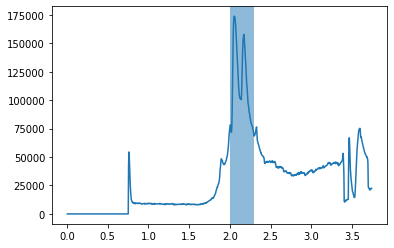

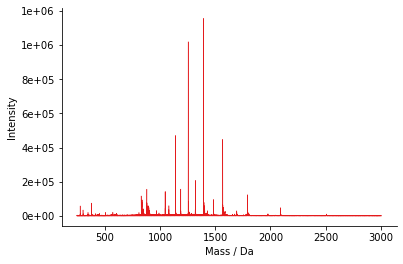

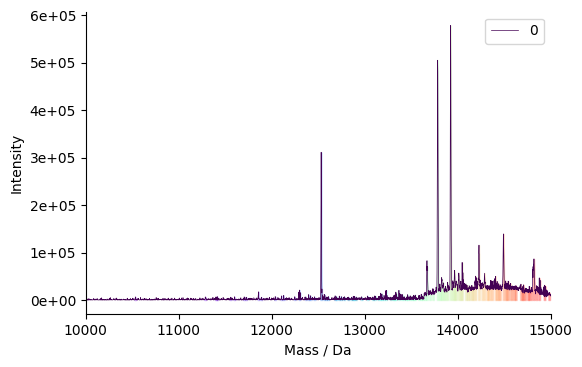

Getting scans: [891, 892]
[[222.462 222.462]]
Execution Time: 0.06754180000007182
Execution Time: 0.6321607999998378
Execution Time: 0.1325645000001714
Peak info saved to: D:\211117 charlie ms\mzml\H7D\UniDec_Figures_and_Files\20211116 2 uM H7D 100 uM AYLPETGG 2 h_BE4_01_80299_extracts.txt
[[1.0000000e+04 8.0958929e+00]
 [1.0001000e+04 1.7487410e+01]
 [1.0002000e+04 2.2282215e+01]
 ...
 [1.4998000e+04 2.6556796e+02]
 [1.4999000e+04 2.5976233e+01]
 [1.5000000e+04 4.4368870e+01]]


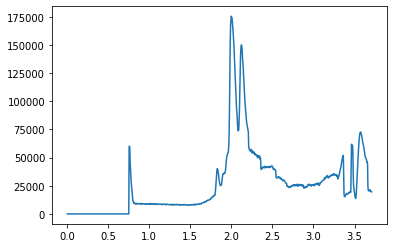

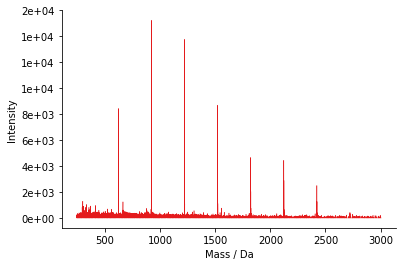

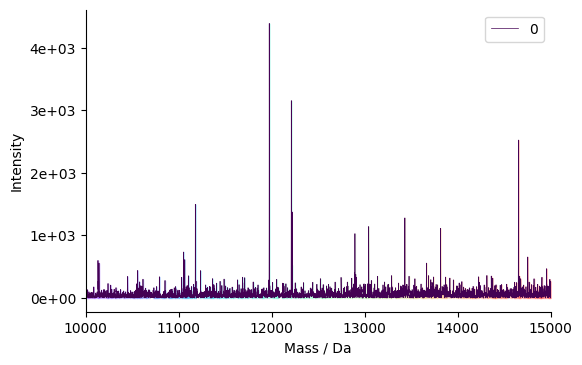

Getting scans: [907, 908]
[[226.379 226.379]]
Execution Time: 0.12404759999981252
Execution Time: 0.8732486999997491
Execution Time: 0.1459975000002487
Peak info saved to: D:\211117 charlie ms\mzml\H7D\UniDec_Figures_and_Files\20211116 2 uM H7D 105 uM AYLPETGG 1 h_BC7_01_80280_extracts.txt
[[1.0000000e+04 1.1627837e+01]
 [1.0001000e+04 2.1581848e+01]
 [1.0002000e+04 3.2253010e+01]
 ...
 [1.4998000e+04 2.0094509e+01]
 [1.4999000e+04 2.4030695e+01]
 [1.5000000e+04 2.2687658e+01]]


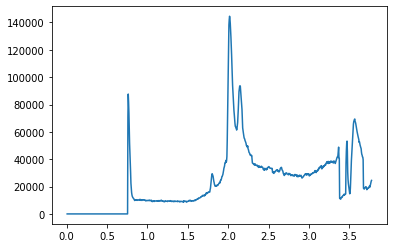

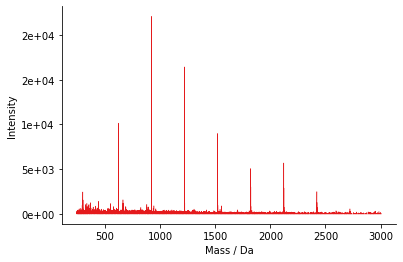

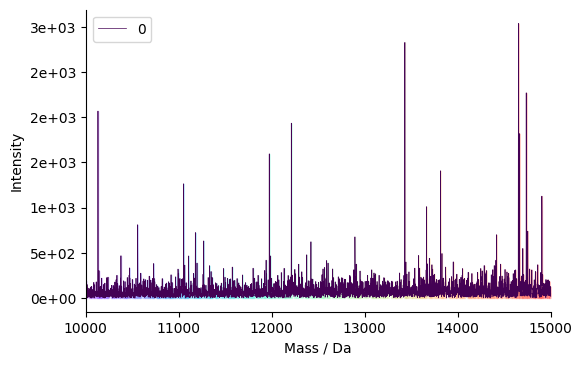

Getting scans: [896, 897]
[[223.649 223.649]]
Execution Time: 0.06775400000014997
Execution Time: 0.4662106999999196
Execution Time: 0.1161882000001242
Peak info saved to: D:\211117 charlie ms\mzml\H7D\UniDec_Figures_and_Files\20211116 2 uM H7D 105 uM AYLPETGG 2 h_BE5_01_80300_extracts.txt
[[1.0000000e+04 1.2599477e-02]
 [1.0001000e+04 9.5882751e+01]
 [1.0002000e+04 9.2318199e+01]
 ...
 [1.4998000e+04 2.9178926e+01]
 [1.4999000e+04 3.1396133e+01]
 [1.5000000e+04 3.9634943e+00]]


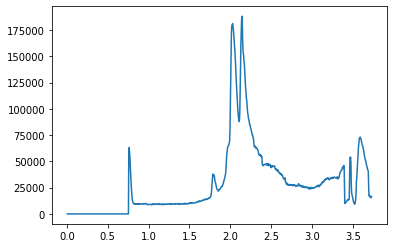

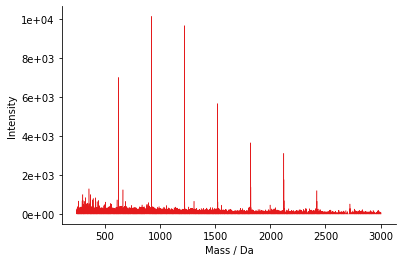

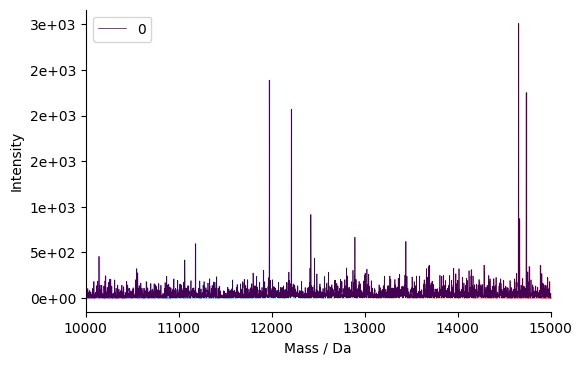

Getting scans: [901, 902]
[[224.891 224.891]]
Execution Time: 0.06375720000005458
Execution Time: 0.6038539999999557
Execution Time: 0.12367219999987356
Peak info saved to: D:\211117 charlie ms\mzml\H7D\UniDec_Figures_and_Files\20211116 2 uM H7D 110 uM AYLPETGG 1 h_BC8_01_80281_extracts.txt
[[1.0000000e+04 7.2880011e+00]
 [1.0001000e+04 1.8847187e+01]
 [1.0002000e+04 1.8000225e+01]
 ...
 [1.4998000e+04 1.3122226e+01]
 [1.4999000e+04 7.2175784e+00]
 [1.5000000e+04 7.2512207e+00]]


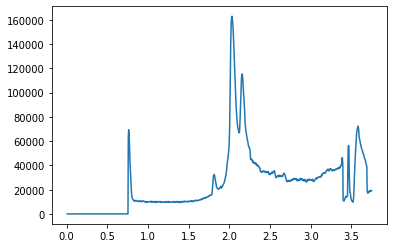

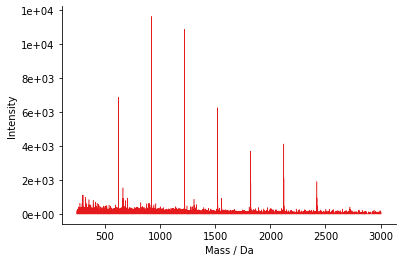

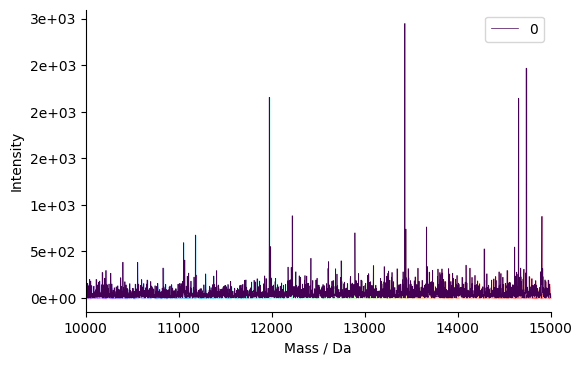

Getting scans: [901, 902]
[[224.905 224.905]]
Execution Time: 0.07887419999997292
Execution Time: 0.6688224000004084
Execution Time: 0.12324189999981172
Peak info saved to: D:\211117 charlie ms\mzml\H7D\UniDec_Figures_and_Files\20211116 2 uM H7D 110 uM AYLPETGG 2 h_BE6_01_80303_extracts.txt
[[1.0000000e+04 1.1348876e+01]
 [1.0001000e+04 2.1583790e+01]
 [1.0002000e+04 6.7812096e+01]
 ...
 [1.4998000e+04 2.8843903e+01]
 [1.4999000e+04 2.1232166e+01]
 [1.5000000e+04 1.4488599e+01]]


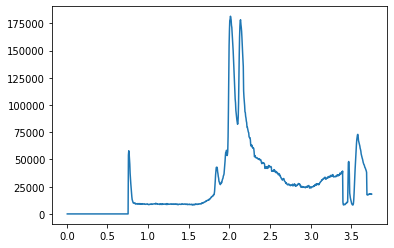

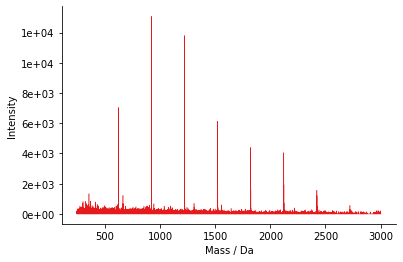

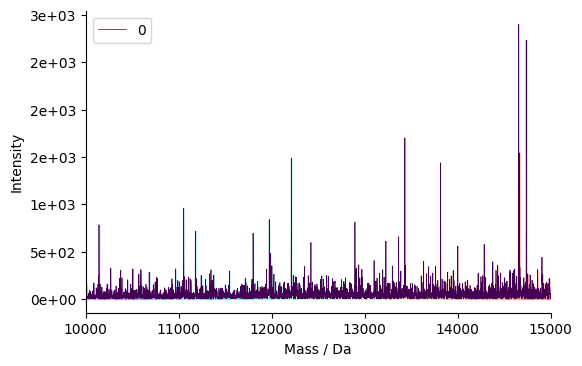

Getting scans: [902, 903]
[[225.126 225.126]]
Execution Time: 0.07000580000021728
Execution Time: 0.6347399000001133
Execution Time: 0.1519572000001972
Peak info saved to: D:\211117 charlie ms\mzml\H7D\UniDec_Figures_and_Files\20211116 2 uM H7D 120 uM AYLPETGG 1 h_BD1_01_80282_extracts.txt
[[1.0000000e+04 0.0000000e+00]
 [1.0001000e+04 1.8983868e+00]
 [1.0002000e+04 3.7557574e-03]
 ...
 [1.4998000e+04 4.7236454e+01]
 [1.4999000e+04 7.5591476e+01]
 [1.5000000e+04 1.0554312e+00]]


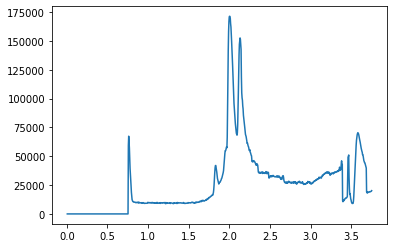

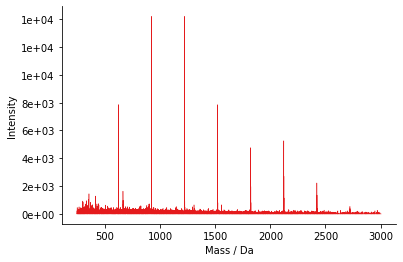

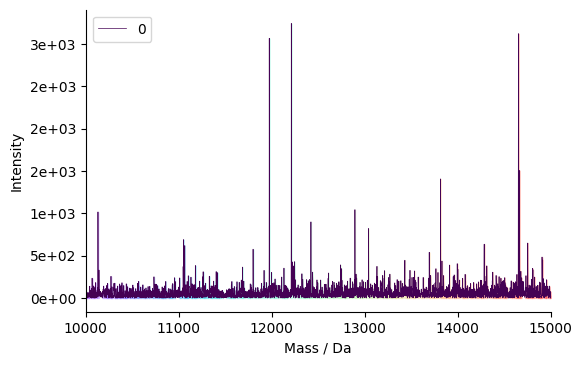

Getting scans: [898, 899]
[[224.255 224.255]]
Execution Time: 0.05915709999999308
Execution Time: 0.47964760000013484
Execution Time: 0.1090251000000535
Peak info saved to: D:\211117 charlie ms\mzml\H7D\UniDec_Figures_and_Files\20211116 2 uM H7D 120 uM AYLPETGG 2 h_BE7_01_80304_extracts.txt
[[1.0000000e+04 0.0000000e+00]
 [1.0001000e+04 7.2404642e+00]
 [1.0002000e+04 1.0188880e+01]
 ...
 [1.4998000e+04 1.0478391e+02]
 [1.4999000e+04 3.6733980e+00]
 [1.5000000e+04 8.4759846e+00]]


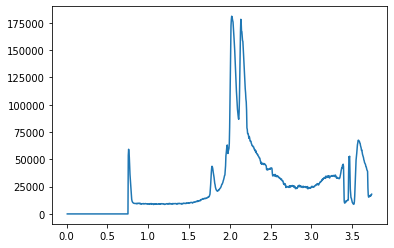

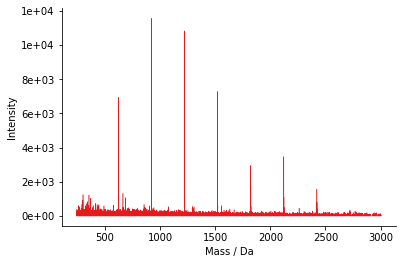

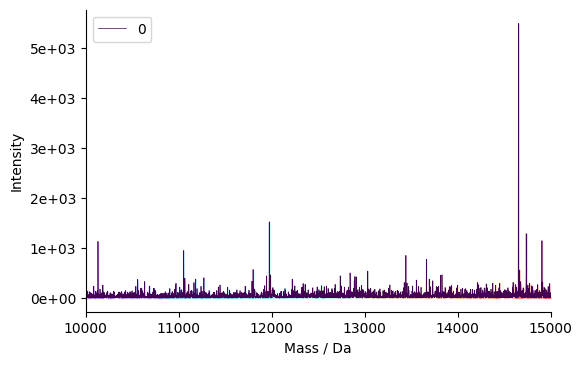

In [23]:
tranges = 2.0, 2.3
peakdata = {}
for eng in engines:
    
#     set tic window ######################### UNCOMMENT FOR NEW FILES PROCESSING
    tranges = tranges[0]*60, tranges[1]*60
    lb, ub = ud.nearest(eng.ticdat[:, 0], tranges[0]), ud.nearest(eng.ticdat[:, 0], tranges[1])
    eng.chrompeaks_tranges = np.array([[eng.ticdat[lb, 0], eng.ticdat[ub, 0]]], dtype = float)
    eng.add_chrom_peaks2()
    print(eng.chrompeaks_tranges)
    plt.plot(eng.ticdat[:, 0]/60, eng.ticdat[:, 1]/60)
    plt.axvspan(eng.ticdat[lb, 0]/60, eng.ticdat[ub, 0]/60, alpha = 0.5)
    ##################################
    
    eng.update_config(masslb = 10000, massub = 15000, peakthresh = 0.01)
    eng.process_data()
    eng.run_unidec()
    try:
        eng.pick_peaks()
    except:
        print(eng.path)
    eng.integrate_all()
    print(eng.data.massdat)
    eng.plot_all(dtype = 'data2', combine = False)
    eng.plot_all(dtype = 'massdat', combine = True, cmap = 'viridis', xlim = [10000, 15000])

    


In [15]:
# for eng in engines:
#     eng.plot_all(dtype = 'data2', combine = False)

In [16]:
# for eng in engines:
#     print(eng.data.__dict__)   
#     print(eng.chrompeaks_tranges)
#     eng.chrompeaks_tranges = [eng.chrompeaks_tranges]
#     eng.process_data()
#     print(eng.data.__dict__)
#     print(eng.data.mzdata)

In [17]:
df['filename'][0]

'20211116 2 uM H7D 100 uM AYLPETGG 1 h_BC6_01_80279.mzML'

In [18]:
for eng in engines:
#     print(df['filename'] == eng.name)
    df.loc[df['filename'] == eng.name, 'engine'] = eng
    df.loc[df['filename']== eng.name, 'Spectra'] = eng.data.spectra[0]
    


AttributeError: 'SeqChrom' object has no attribute 'name'

In [ ]:
window = 10

specieslist = splist

for index, row in df.iterrows():
    data_masses = np.array([p.mass for p in row['Spectra'].pks.peaks])
    theory_masses = np.array([sp.Mass for sp in specieslist])
#     print("theory masses", theory_masses)
#     print("data_masses", data_masses)
    
    
    pks = np.array([p for p in row['Spectra'].pks.peaks])

    # match algorithm 
    tm, dm = np.meshgrid(theory_masses, data_masses)

    diff = abs(tm - dm)

    diff[diff>window] = np.nan
    
    for i, d in enumerate(diff):
        if np.isnan(d).all()==False:
            minimum = np.nanargmin(d)
            data_peak = data_masses[i]
            
            print(data_peak)
            print(specieslist[minimum])
#             specieslist[minimum].peak = pks[i]
#             specieslist[minimum].integral = pks[i].integral[0]
#             print(specieslist[minimum])
#             print("{}, {} = {}".format(row[row.index.isin(row['Species'])][minimum].__name__, data_peak, pks[i]))

#             row[row.index.isin(row['Species'])][minimum].integral = pks[i].integral[0]
#             row[row.index.isin(row['Species'])][minimum].peak = pks[i]
#             np.append(rowints, pks[i].integral[0])
#             print(row[row.index.isin(row['Species'])][minimum].integral)

In [ ]:
list(speciesmap['Species'])

In [ ]:
np.array(list(speciesdct.values()))

In [ ]:
species = list(speciesdct.keys())
theory_masses = list(speciesdct.values())

def match_peaks2(self, theory_masses, data_masses, window = 10):
    """Peak matching algorithm with species defined in reaction map. Window is in Daltons."""
    self.species_data = {}

    tm, dm = np.meshgrid(theory_masses, data_masses)
    diff = abs(tm - dm)
    diff[diff>window] = np.nan

    for i, d in enumerate(diff):
        if np.isnan(d).all()==False:
            minimum = np.nanargmin(d)
            data_peak = data_masses[i]
            self.species_data[minimum].peak = self.pks[i]
            self.species_data[minimum].integral = self.pks[i].integral[0]
            print("{} = {}".format(data_peak, t.pks[i]))

    return self

                    

In [ ]:
engines2 = []
for eng in engines:
#     print([i[0] for i in eng.data.spectra[0].integrals])
    ints = [i[0] for i in eng.data.spectra[0].integrals]
#     print(np.array(ints))
    eng = match_peaks2(eng, theory_masses, ints)
    print(theory_masses, ints)

In [ ]:
def percentage_species(self, dct):
    for t in dct:
        ints = np.array([s.integral for s in t.species])
        sum_ints = np.sum(ints)
        for s in t.species:
            s.percentage = s.integral/sum_ints

    return dct